In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


## Data processing

100%|██████████| 121/121 [01:39<00:00,  1.22it/s]


TypeError: Colorbar.__init__() got an unexpected keyword argument 'title'

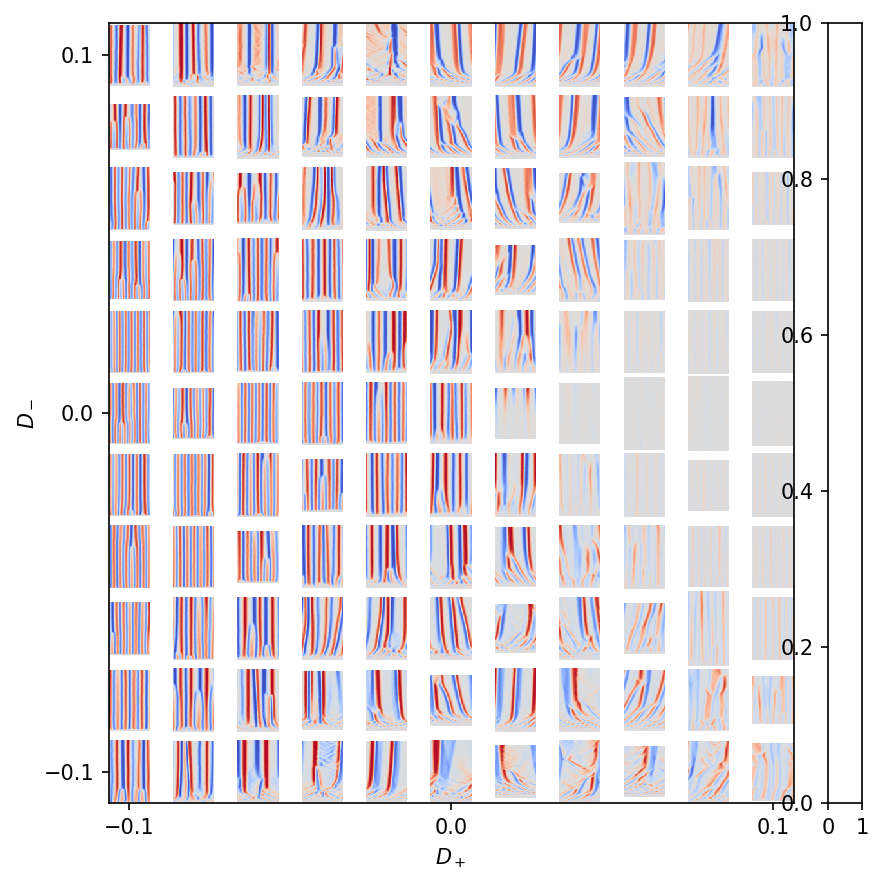

In [8]:
from tqdm import tqdm
from glob import glob
import json


data_dir = '/home/jcolen/data/sociohydro/2024-02-05_MCPhaseDiagram/data'
folders = sorted(glob(f'{data_dir}/*'))

fig, ax = plt.subplots(dpi=150, figsize=(6, 6), tight_layout=True)

for folder in tqdm(folders):
    data_file = glob(f'{folder}/*hdf5')
    param_file = glob(f'{folder}/*json')
    with open(param_file[0]) as pfile:
        p = json.load(pfile)
    x = np.arange(p["grid_size"])
    with h5py.File(data_file[0]) as d:
        ϕA = np.zeros((len(d.keys()), p["grid_size"]))
        ϕB = np.zeros((len(d.keys()), p["grid_size"]))
        t = np.zeros(len(d.keys()))
        for kidx, key in enumerate(d.keys()):
            ϕA[kidx] = d[key]["state"][0, :]
            ϕB[kidx] = d[key]["state"][1, :]
            t[kidx] = d[key]["sweep"][()]
    ϕA /= p["capacity"]
    ϕB /= p["capacity"]
    t *= p["dt"]
    
    Dp = p["kappa"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2 - p["temperature"] * p["fill"][0]
    Dm = p["delta"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2
    
    a = ax.pcolormesh(Dp + (x-x.max()/2) * 2e-4, Dm + (t-t.max()/2) * 2e-6, ϕA - ϕB,
                      cmap="coolwarm", vmin=-1, vmax=1,
                      rasterized=True)


ax.set(xticks=[-0.1, 0, 0.1], yticks=[-0.1, 0, 0.1],
       xlabel=r"$D_+$", ylabel=r"$D_-$")
cax = ax.inset_axes([1.05, 0.0, 0.05, 1])
fig.colorbar(a, cax=cax, ax=ax, title=r"$\phi_A - \phi_B$")

In [11]:
Dm_array = np.zeros(len(folders))
Dp_array = np.zeros(len(folders))

for fidx, folder in enumerate(tqdm(folders)):
    data_file = glob(f'{folder}/*hdf5')
    param_file = glob(f'{folder}/*json')
    with open(param_file[0]) as pfile:
        p = json.load(pfile)
    x = np.arange(p["grid_size"])
    
    Dp_array[fidx] = p["kappa"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2 - p["temperature"] * p["fill"][0]
    Dm_array[fidx] = p["delta"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2

seg_idx = np.logical_and(Dm_array > Dp_array, Dm_array < -Dp_array)
int_idx = np.logical_and(Dm_array < Dp_array, Dm_array > -Dp_array)
mig1_idx = np.logical_and(Dm_array < Dp_array, Dm_array < -Dp_array)
mig2_idx = np.logical_and(Dm_array > Dp_array, Dm_array > -Dp_array)

dynamic_type = np.empty(len(folders), dtype=object)
dynamic_type[seg_idx] = "segregated"
dynamic_type[int_idx] = "integrated"
dynamic_type[mig1_idx] = "migration1"
dynamic_type[mig2_idx] = "migration2"

dynamic_keys = np.array([(f, d) for f,d in zip(folders, dynamic_type)])

np.savetxt(f"{data_dir}/dynamic_keys.csv", dynamic_keys, 
delimiter=",", header="file,dynamic_type", fmt="%s,%s", comments="#")

100%|██████████| 121/121 [00:00<00:00, 1243.90it/s]


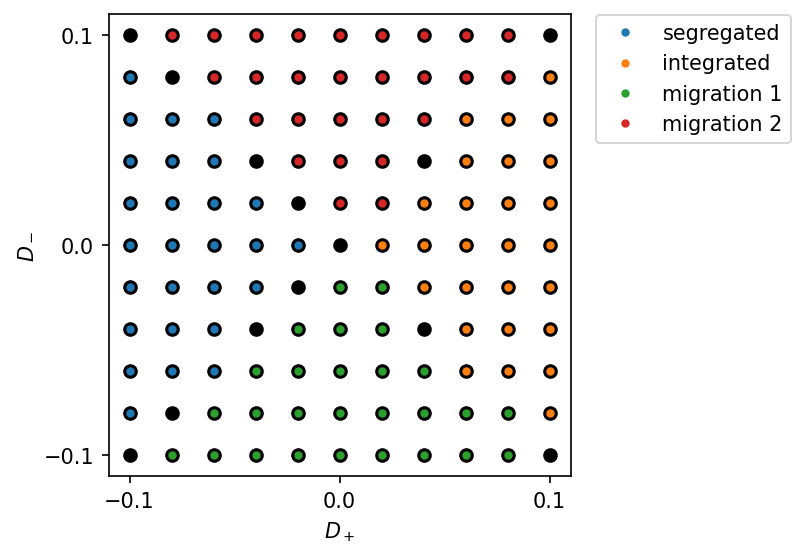

In [13]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 4))
ax.plot(Dp_array, Dm_array, "ko")
ax.plot(Dp_array[seg_idx], Dm_array[seg_idx], ".", label="segregated")
ax.plot(Dp_array[int_idx], Dm_array[int_idx], ".", label="integrated")
ax.plot(Dp_array[mig1_idx], Dm_array[mig1_idx], ".", label="migration 1")
ax.plot(Dp_array[mig2_idx], Dm_array[mig2_idx], ".", label="migration 2")

ax.set(xlabel=r"$D_+$", ylabel=r"$D_-$",
       xticks=[-0.1, 0, 0.1], yticks=[-0.1, 0, 0.1])

ax.set_aspect(1)
ax.legend(loc="center right", bbox_to_anchor=[1.5, 0.86])
# plt.tight_layout()
fig.savefig("2024-02-14_phaseDefinitions.pdf", bbox_inches="tight")

# Applying Fenics to simulations

(64,) (878,) (878, 64) (878, 64)


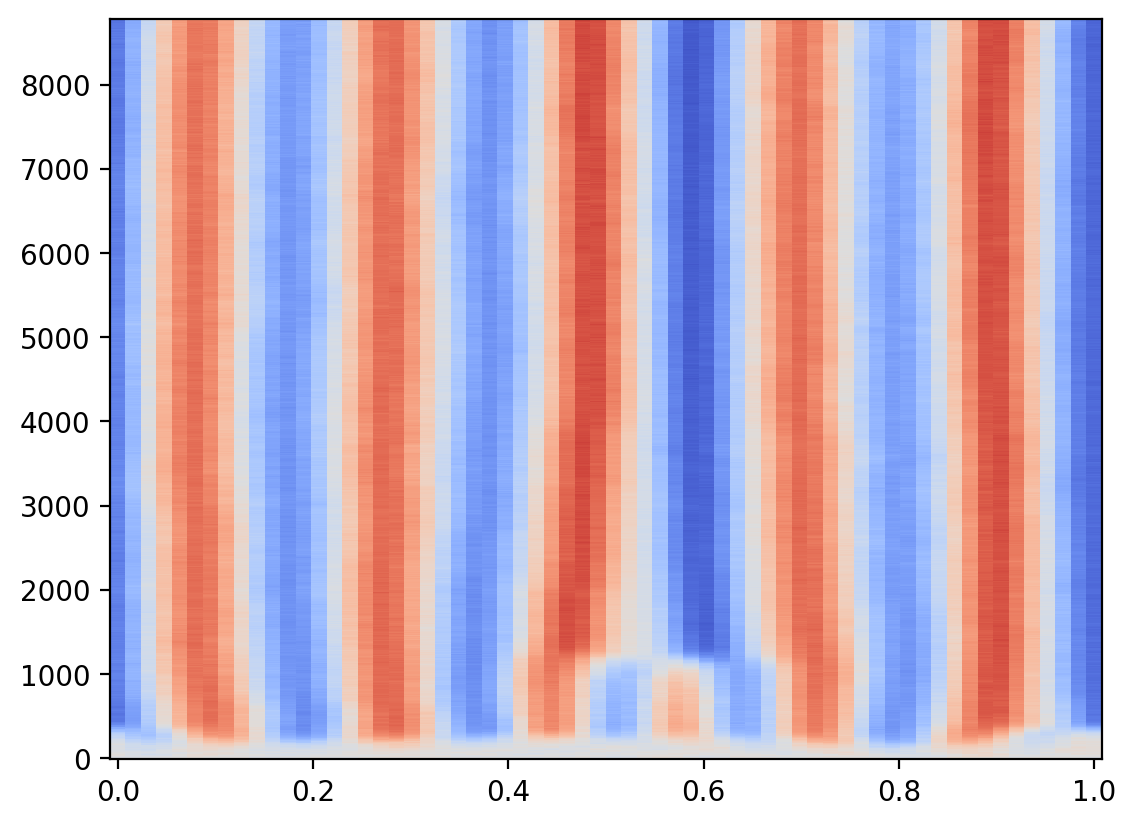

In [11]:
from glob import glob
import json
import h5py

folder = '/home/jcolen/data/sociohydro/2024-02-05_MCPhaseDiagram/data/delta-0.00_kappa-0.24/'

data_file = glob(f'{folder}/*hdf5')
param_file = glob(f'{folder}/*json')
with open(param_file[0]) as pfile:
    p = json.load(pfile)
x = np.linspace(0, 1, p["grid_size"])
with h5py.File(data_file[0]) as d:
    ϕA = np.zeros((len(d.keys()), p["grid_size"]))
    ϕB = np.zeros((len(d.keys()), p["grid_size"]))
    t = np.zeros(len(d.keys()))
    for kidx, key in enumerate(d.keys()):
        ϕA[kidx] = d[key]["state"][0, :]
        ϕB[kidx] = d[key]["state"][1, :]
        t[kidx] = d[key]["sweep"][()]
ϕA /= p["capacity"]
ϕB /= p["capacity"]
t *= p["dt"]

Dp = p["kappa"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2 - p["temperature"] * p["fill"][0]
Dm = p["delta"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2

print(x.shape, t.shape, ϕA.shape, ϕB.shape)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.pcolormesh(x, t, ϕA - ϕB,
                      cmap="coolwarm", vmin=-1, vmax=1,
                      rasterized=True)


1.3877787807814457e-17
Setting up variational problem
0.00015625
Starting to integrate


100%|██████████| 50/50 [00:00<00:00, 281.64it/s]


Text(0.5, 0.98, '$D_+ = -0.040, D_- = -0.000$')

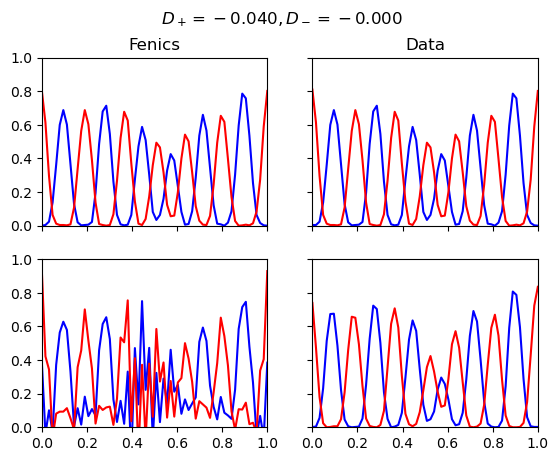

In [42]:
import dolfin as dlf
import dolfin_adjoint as d_ad
from ufl import dot, grad, dx
from tqdm.auto import tqdm

def plot_mesh(ax, f, mesh, **kwargs):
    x = mesh.coordinates()[:,0]
    ax.plot(x, f.compute_vertex_values(), **kwargs)

class PeriodicBoundary(dlf.SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[0] < dlf.DOLFIN_EPS and x[0] > -dlf.DOLFIN_EPS and on_boundary)
    
    def map(self, x, y):
        y[0] = x[0] - 1.0

def scalar_to_mesh(f, FctSpace):
    # No long as simple now that we have periodicBC
    d2v = dlf.dof_to_vertex_map(V)

    dof_coords = FctSpace.tabulate_dof_coordinates().copy()


# Mesh has vertices exactly at x coordinates
mesh = dlf.UnitIntervalMesh(x.shape[0]-1)
verts = mesh.coordinates()
print(np.mean(np.abs(verts[:,0] - x)))

v = dlf.FiniteElement('Lagrange', mesh.ufl_cell(), 1)
vv = v*v
pbc = PeriodicBoundary()
V = dlf.FunctionSpace(mesh, v, constrained_domain=pbc)
VV = dlf.FunctionSpace(mesh, vv, constrained_domain=pbc)

d2v = dlf.dof_to_vertex_map(V)
v2d = dlf.vertex_to_dof_map(V)

phiA0 = dlf.Function(V)
phiB0 = dlf.Function(V)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

#
# Plot Initial conditions
#

phiA0.vector().set_local(ϕA[t0, d2v[:-1]])
phiB0.vector().set_local(ϕB[t0, d2v[:-1]])
plot_mesh(ax[0, 0], phiA0, mesh, color='blue')
plot_mesh(ax[0, 0], phiB0, mesh, color='red')

t0, sim_len = 50, 50

ax[0,1].plot(x, ϕA[t0], color='blue')
ax[0,1].plot(x, ϕB[t0], color='red')

# 
# Plot Final conditions
#

print('Setting up variational problem')
phiA, phiB = dlf.TrialFunctions(VV)
u, v = dlf.TestFunctions(VV)

Daa = 0.01
Dab = 0.5 * (Dp - Dm)
Dba = 0.5 * (Dp + Dm)
Dbb = 0.01

print(p['dt'] / p['grid_size'])
dt = p['dt'] / p['grid_size']

a = phiA * u * dx(mesh) + phiB * v * dx(mesh)
a += dt * dot(Daa * grad(phiA), grad(u)) * dx(mesh)
a += dt * dot(Dab * grad(phiB), grad(u)) * dx(mesh)
a += dt * dot(Dba * grad(phiA), grad(v)) * dx(mesh)
a += dt * dot(Dbb * grad(phiB), grad(v)) * dx(mesh)

L = phiA0 * u * dx(mesh) + phiB0 * v * dx(mesh)
ab = dlf.Function(VV)

print('Starting to integrate')
for i in tqdm(range(sim_len)):
    dlf.solve(a == L, ab)
    ai,bi = ab.split(True)
    phiA0.assign(ai)
    phiB0.assign(bi)

#phiA0.vector().set_local(ϕA[-1, d2v])
#phiB0.vector().set_local(ϕB[-1, d2v])
plot_mesh(ax[1, 0], phiA0, mesh, color='blue')
plot_mesh(ax[1, 0], phiB0, mesh, color='red')

ax[1,1].plot(x, ϕA[t0+sim_len], color='blue')
ax[1,1].plot(x, ϕB[t0+sim_len], color='red')

ax[0,0].set(xlim=[0, 1], ylim=[0, 1])
ax[0,0].set_title('Fenics')
ax[0,1].set_title('Data')

fig.suptitle(f'$D_+ = {Dp:.3f}, D_- = {Dm:.3f}$')

# Dataset and model testing

Loaded state dict from file


[(0.0, 1.0), (0.0, 1.0)]

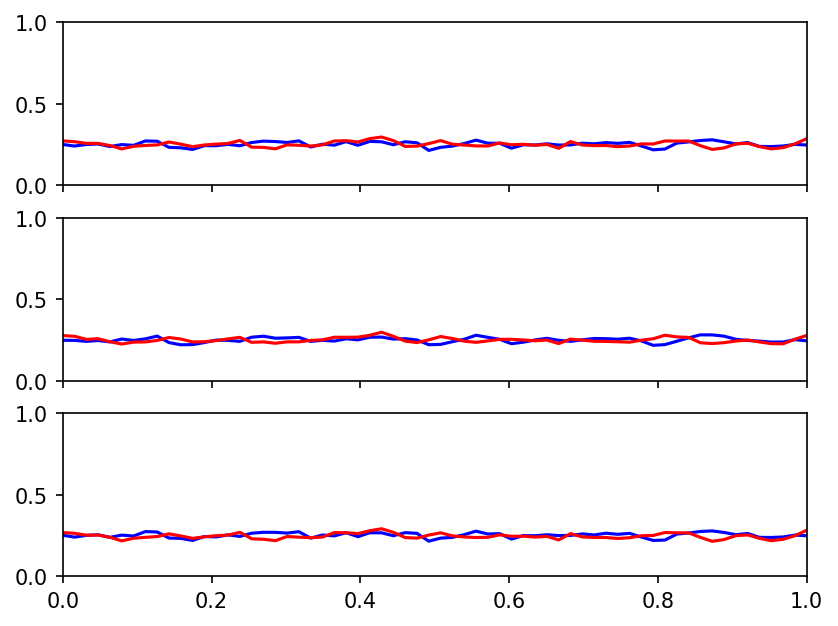

In [3]:
from data_processing import SimulationDataset
from dolfin_problems import SimulationProblem
from pbnn import SimulationPBNN
import pandas as pd

info = pd.read_csv('/home/jcolen/data/sociohydro/2024-02-05_MCPhaseDiagram/data/dynamic_keys.csv')
folders = info.loc[info.dynamic_type == 'segregated', '#file'].values
folder = folders[0]
ds = SimulationDataset(folder)
model = SimulationPBNN()
info = torch.load('models/simulation/SimulationPBNN_1.ckpt')
model.load_state_dict(info['state_dict'])
print('Loaded state dict from file')

sample = ds[5]

fig, ax = plt.subplots(3, 1, dpi=150, sharex=True, sharey=True)

ab0 = sample['ab0']
ab1 = sample['ab1']

ax[0].plot(ds.x, sample['ab0'][0], color='blue')
ax[0].plot(ds.x, sample['ab0'][1], color='red')

ax[1].plot(ds.x, sample['ab1'][0], color='blue')
ax[1].plot(ds.x, sample['ab1'][1], color='red')

params = model.forward(sample['ab0'][None], sample['problem'].FctSpace)
problem = sample['problem']
problem.set_params(**params)

ab = problem.forward()
a,b = ab.split(True)
ax[2].plot(ds.x, a.compute_vertex_values(), color='blue')
ax[2].plot(ds.x, b.compute_vertex_values(), color='red')

ax[0].set(xlim=[0,1], ylim=[0,1])


# Simulating a trained model

Loaded state dict from file
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
Simulating for 100.0
(63,)
(63,)


  0%|          | 0/10 [00:00<?, ?it/s]

(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)


100%|██████████| 10/10 [00:00<00:00, 80.94it/s]

(63,)
(63,)


[(0.0, 1.0), (0.0, 1.0)]

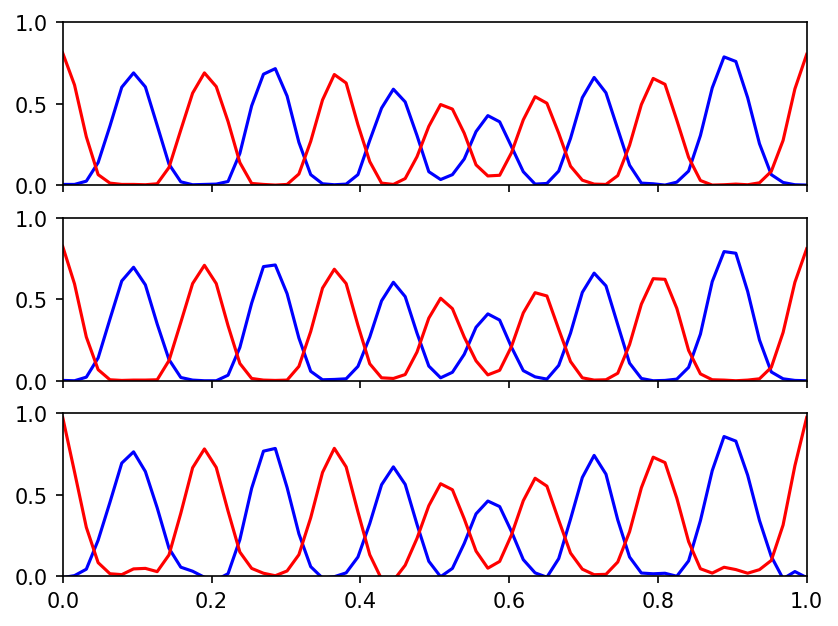

In [48]:
import torch
import dolfin_adjoint as d_ad
import pandas as pd
from data_processing import SimulationDataset
from pbnn import SimulationPBNN

device = torch.device('cuda:0')

info = pd.read_csv('/home/jcolen/data/sociohydro/2024-02-05_MCPhaseDiagram/data/dynamic_keys.csv')
folders = info.loc[info.dynamic_type == 'segregated', '#file'].values
folder = folders[0]
ds = SimulationDataset(folder)
ds.validate()
model = SimulationPBNN().to(device)
info = torch.load('models/simulation/SimulationPBNN_1.ckpt')
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

sample0 = ds[50]
sample1 = ds[60]
tmax = sample1['t'] - sample0['t']
print(f'Simulating for {tmax}')

fig, ax = plt.subplots(3, 1, dpi=150, sharex=True, sharey=True)

ab0 = sample0['ab0']
ab1 = sample1['ab0']

ax[0].plot(ds.x, sample0['ab0'][0], color='blue')
ax[0].plot(ds.x, sample0['ab0'][1], color='red')

ax[1].plot(ds.x, sample1['ab0'][0], color='blue')
ax[1].plot(ds.x, sample1['ab0'][1], color='red')

with torch.no_grad(), d_ad.stop_annotating():
    sample0['ab0'] = sample0['ab0'].to(device)
    a0, b0, ab = model.simulate(sample0, ds.mesh, tmax=tmax, dt=ds.dt)
    sample0['ab0'] = ab.cpu()
    sample0['dt'] += tmax

    ab = ab.cpu().numpy()

ax[2].plot(ds.x, ab[0], color='blue')
ax[2].plot(ds.x, ab[1], color='red')

ax[0].set(xlim=[0,1], ylim=[0,1])